In [ ]:
from google.colab import drive
drive.mount('content.drive')

Mounted at content.drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import string
import nltk
nltk.download('stopwords')
from nltk.tokenize.toktok import ToktokTokenizer
import re
import spacy
nlp = spacy.load('en_core_web_sm', disable=['ner'])
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
import pickle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Analysis of data

In [ ]:
#We import the dataset with which we will work: "suspicious_tweets".
data= pd.read_csv('/content/content.drive/MyDrive/TP_Final/suspicious_tweets.csv')
data.head()

,message,label
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",1
1,is upset that he can't update his Facebook by ...,1
2,@Kenichan I dived many times for the ball. Man...,1
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",1


In [ ]:
#It has 60,000 records (tweets) and 2 fields (the content of the tweet and a sentiment rating).
data.shape

(60000, 2)

In [ ]:
#We open by rating tweets (0="suspicious", 1="non suspicious").
values_count=data['label'].value_counts()
values_count

1    53855
0     6145
Name: label, dtype: int64

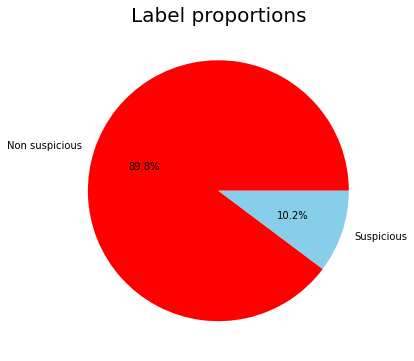

In [ ]:
plt.figure(figsize=(18,6))
plt.pie(values_count,labels=['Non suspicious','Suspicious'],colors=['red', 'skyblue'], autopct = '%1.1f%%')
plt.title("Label proportions",fontsize=20)
plt.show()

# Data cleaning (methods)

In [ ]:
#We define a function that takes samples of size N, from the 2 subsets that make up the dataset ("suspiciuss" and "non suspicious" tweets).
#Then we append them and shuffle over the new set. The function returns a new "train" dataset.
def balance_classes(data):
    #Definimos N=5.000
    n_Class = 5000
    label_0=data[data['label']==0].sample(n=n_Class)
    label_1=data[data['label']==1].sample(n=n_Class)
    train = pd.concat([label_1,label_0])
    train=shuffle(train)
    return train

# For this work we will use text mining techniques. For this we will implement NLTK (Natural Language Toolkit), a library for
#natural language processing. Our goal will be tokenize the tweets and build "bags of words" with them.
#We remove the punctuation of the tweets.
def remove_punctuation(text):
  for punctuation in string.punctuation:
    text=text.replace(punctuation,'')
  return text

#We remove stopwords from tweets.
def remove_stopwords(text,is_lower_case=True):
  tokenizer = ToktokTokenizer()

  stop_words_list = nltk.corpus.stopwords.words('english')
  stop_words_list.remove('no')
  stop_words_list.remove('not')

  tokens=tokenizer.tokenize(text)
  tokens=[token.strip() for token in tokens]
  if is_lower_case:
    filterd_tokens=[token for token in tokens if token not in stop_words_list]
  else:
    filterd_tokens=[token for token in tokens if token.lower() not in stop_words_list]
  filterd_text=' '.join(filterd_tokens)
  return filterd_text

#We remove special characters.
def remove_special_characters(text):
  text=re.sub('[^a-zA-z0-9\s]','',text)
  return text

#We remove characters from HTML
def remove_html(text):
  html_pattran=re.compile('<.*?>')
  return html_pattran.sub(r' ',text)

#We remove characters from URL
def remove_url(text):
  url=re.compile(r'https?://\S+|www\.\S+')
  return url.sub(r' ',text)

#we remove numbers
def remove_numbers(text):
  text=''.join([i for i in text if not i.isdigit()])
  return text

def cleanse(word):
  rx=re.compile(r'\D*\d')
  if rx.match(word):
    return ' '
  return word


def alpha_numeric(strings):
  nstrings=[" ".join(filter(None,(cleanse(word) for word in string.split()))) for string in strings.split()]
  str1=" ".join(nstrings)
  return str1

#We pass the tweets through a lemmatizer (Lemmatization)
def lemmatize(text):
  text=nlp(text)
  text=" ".join([word.lemma_ if word.lemma_!='-PRON-' else word for word in text])
  return text

# Data cleaning (Application)

In [ ]:
def clean_dataset(data):
  data['message'] = data['message'].apply(remove_punctuation)
  data['message'] = data['message'].apply(remove_stopwords)
  data['message'] = data['message'].apply(remove_special_characters)
  data['message'] = data['message'].apply(remove_html)
  data['message'] = data['message'].apply(remove_url)
  data['message'] = data['message'].apply(remove_numbers)
  data['message'] = data['message'].apply(alpha_numeric)
  data['message'] = data['message'].apply(lemmatize)
  return data

cleaned_data = data.pipe(balance_classes).pipe(clean_dataset)

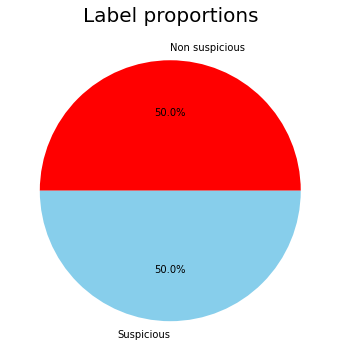

In [ ]:
#Here we graph the new distribution of the already balanced classes
values_count=cleaned_data['label'].value_counts()
values_count

plt.figure(figsize=(18,6))
plt.pie(values_count,labels=['Non suspicious','Suspicious'],colors=['red', 'skyblue'], autopct = '%1.1f%%')
plt.title("Label proportions",fontsize=20)
plt.show()

# Models

In [ ]:
X=cleaned_data['message'].values
y=cleaned_data['label'].values

In [ ]:
vector=TfidfVectorizer(lowercase=False)
vector.fit(X)
X=vector.fit_transform(X)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25, shuffle=True, random_state = 5, stratify=y)

### Logistic Regression

In [ ]:
logistic=LogisticRegression()
logistic.fit(X_train,y_train)
logistic_pred=logistic.predict(X_test)
print(f'The score for logistic regression with the train set is {logistic.score(X_train,y_train)}')
print(f'The score for logistic regression with the test set is {logistic.score(X_test,y_test)}')
print(f'The accuracy for logistic regression is {accuracy_score(y_test,logistic_pred)}')

El score para regresion logistica con el set de train es 0.9365333333333333
El score para regresion logistica con el set de test es 0.8376
El accuracy para regresion logistica es 0.8376


              precision    recall  f1-score   support

           0       0.94      0.72      0.82      1250
           1       0.78      0.95      0.85      1250

    accuracy                           0.84      2500
   macro avg       0.86      0.84      0.84      2500
weighted avg       0.86      0.84      0.84      2500



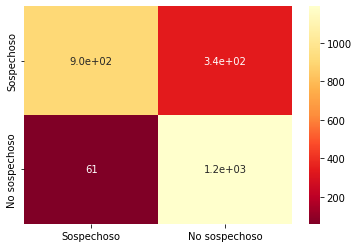

In [ ]:
print(classification_report(y_test,logistic_pred))
cn=confusion_matrix(y_test,logistic_pred)
sns.heatmap(cn,annot=True,cmap='YlOrRd_r',xticklabels=['Sospechoso','No sospechoso'],yticklabels=['Sospechoso','No sospechoso'])

In [ ]:
scores = cross_val_score(logistic, X_train,y_train, cv=5)
print(scores)
print(scores.mean())

[0.83333333 0.81933333 0.82933333 0.83533333 0.81733333]
0.8269333333333334


### Decision Tree

In [ ]:
tree=DecisionTreeClassifier()
tree.fit(X_train,y_train)
tree_pred=tree.predict(X_test)

print(f'The score for desicion tree with the train set is {tree.score(X_train, y_train)}')
print(f'The score for decision tree with the test set is {tree.score(X_test, y_test)}')
print(f'The accuracy for decision tree is {accuracy_score(y_test,tree_pred)}')

El score para arboles de decision con el set de train es 1.0
El score para arboles de decision con el set de test es 0.8964
El accuracy para arboles de decision es 0.8964


              precision    recall  f1-score   support

           0       0.93      0.86      0.89      1250
           1       0.87      0.94      0.90      1250

    accuracy                           0.90      2500
   macro avg       0.90      0.90      0.90      2500
weighted avg       0.90      0.90      0.90      2500



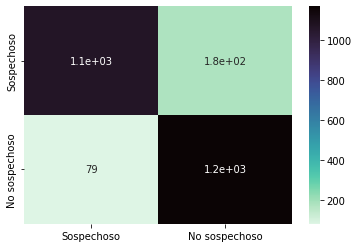

In [ ]:
print(classification_report(y_test,tree_pred))
cn=confusion_matrix(y_test,tree_pred)
sns.heatmap(cn,annot=True,cmap='mako_r', xticklabels=['Sospechoso','No sospechoso'],yticklabels=['Sospechoso','No sospechoso'])

In [ ]:
scores = cross_val_score(tree, X_train,y_train, cv=5)
print(scores)
print(scores.mean())

[0.88866667 0.88066667 0.89133333 0.89933333 0.89933333]
0.8918666666666667


### Random Forest

In [ ]:
random=RandomForestClassifier()
random.fit(X_train,y_train)
random_pred=random.predict(X_test)

print(f'The score for random forest with the train set is {random.score(X_train, y_train)}')
print(f'The score for random forest with the test set is {random.score(X_test, y_test)}')
print(f'The accuracy for random forest is {accuracy_score(y_test,random_pred)}')

El score para random forest con el set de train es 1.0
El score para random forest con el set de test es 0.8732
El accuracy para random forest es 0.8732


              precision    recall  f1-score   support

           0       0.97      0.77      0.86      1250
           1       0.81      0.97      0.88      1250

    accuracy                           0.87      2500
   macro avg       0.89      0.87      0.87      2500
weighted avg       0.89      0.87      0.87      2500



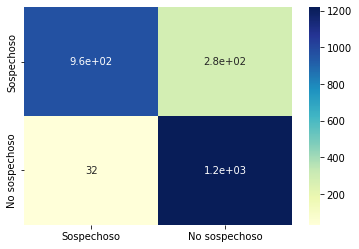

In [ ]:
print(classification_report(y_test,random_pred))
cn=confusion_matrix(y_test,random_pred)
sns.heatmap(cn,annot=True,cmap='YlGnBu', xticklabels=['Sospechoso','No sospechoso'],yticklabels=['Sospechoso','No sospechoso'])

In [ ]:
scores = cross_val_score(random, X_train,y_train, cv=5)
print(scores)
print(scores.mean())

[0.86866667 0.84933333 0.86933333 0.874      0.862     ]
0.8646666666666667


### Multinomial NB

In [ ]:
multinomial=MultinomialNB()
multinomial.fit(X_train,y_train)
multinomial_pred=multinomial.predict(X_test)

print(f'The score for rmultinomial NB with the train set is {multinomial.score(X_train, y_train)}')
print(f'The score for multinomial NB with the test set is {multinomial.score(X_test, y_test)}')
print(f'The accuracy for multinomial NB is {accuracy_score(y_test,multinomial_pred)}')

El score para multinomial NB con el set de train es 0.9718666666666667
El score para multinomial NB con el set de test es 0.7904
El accuracy para multinomial NB es 0.7904


              precision    recall  f1-score   support

           0       0.75      0.88      0.81      1250
           1       0.85      0.70      0.77      1250

    accuracy                           0.79      2500
   macro avg       0.80      0.79      0.79      2500
weighted avg       0.80      0.79      0.79      2500



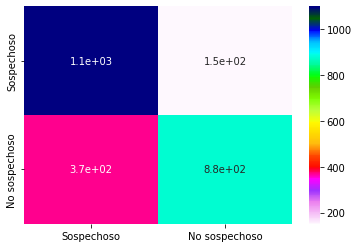

In [ ]:
print(classification_report(y_test,multinomial_pred))
cn=confusion_matrix(y_test,multinomial_pred)
sns.heatmap(cn,annot=True,cmap='gist_ncar_r', xticklabels=['Sospechoso','No sospechoso'],yticklabels=['Sospechoso','No sospechoso'])

In [ ]:
scores = cross_val_score(multinomial, X_train,y_train, cv=5)
print(scores)
print(scores.mean())

[0.76733333 0.768      0.79133333 0.778      0.764     ]
0.7737333333333334


### XGBoost

In [ ]:
xgb=XGBClassifier()
xgb.fit(X_train,y_train)
xgb_pred=xgb.predict(X_test)

print(f'The score for XGBoost with the train set is {xgb.score(X_train, y_train)}')
print(f'The score for XGBoost with the test set is {xgb.score(X_test, y_test)}')
print(f'The accuracy for XGBoost is {accuracy_score(y_test,xgb_pred)}')

El score para XGBoost con el set de train es 0.7946666666666666
El score para XGBoost con el set de test es 0.7924
El accuracy para XGBoost es 0.7924


              precision    recall  f1-score   support

           0       0.99      0.59      0.74      1250
           1       0.71      1.00      0.83      1250

    accuracy                           0.79      2500
   macro avg       0.85      0.79      0.78      2500
weighted avg       0.85      0.79      0.78      2500



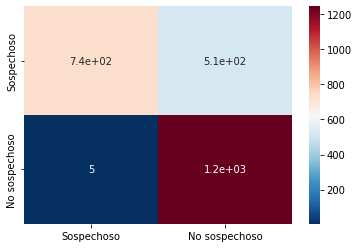

In [ ]:
print(classification_report(y_test,xgb_pred))
cn=confusion_matrix(y_test,xgb_pred)
sns.heatmap(cn,annot=True,cmap='RdBu_r', xticklabels=['Sospechoso','No sospechoso'],yticklabels=['Sospechoso','No sospechoso'])

In [ ]:
scores = cross_val_score(xgb, X_train,y_train, cv=5)
print(scores)
print(scores.mean())

[0.79466667 0.772      0.79866667 0.81133333 0.784     ]
0.7921333333333334


## Change of hyperparameters

In [ ]:
def random_search(model,X_train,Y_train,param_grid):
  random=RandomizedSearchCV(estimator=model,param_distributions=param_grid,n_iter=20,cv=3,verbose=2,random_state=42,n_jobs=-1)
  random.fit(X_train,y_train)
  print(random.best_params_)

### Logistic Regression

In [ ]:
log_para_grid = {
  'C':10.0 **np.arange(-2,3),
  'penalty':['none','l2']
}

random_search(LogisticRegression(),X_train,y_train,log_para_grid)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 10 is smaller than n_iter=20. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


{'penalty': 'l2', 'C': 100.0}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
logistic_rnd=LogisticRegression(**{'penalty': 'l2', 'C': 100.0})
logistic_rnd.fit(X_train,y_train)
logistic_rnd_pred=logistic_rnd.predict(X_test)

print(f'The score for logistic regression with the train set is {logistic_rnd.score(X_train,y_train)}')
print(f'The score for logistic regression with the test set is {logistic_rnd.score(X_test,y_test)}')
print(f'The accuracy for logistic regression is {accuracy_score(y_test,logistic_rnd_pred)}')

El score para regresion logistica con el set de train es 1.0
El score para regresion logistica con el set de test es 0.874
El accuracy para regresion logistica es 0.874


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


              precision    recall  f1-score   support

           0       0.93      0.81      0.86      1250
           1       0.83      0.94      0.88      1250

    accuracy                           0.87      2500
   macro avg       0.88      0.87      0.87      2500
weighted avg       0.88      0.87      0.87      2500



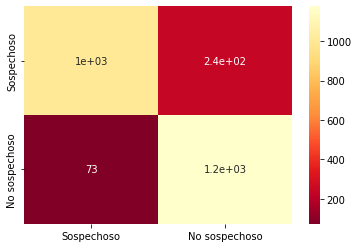

In [ ]:
print(classification_report(y_test,logistic_rnd_pred))
cn=confusion_matrix(y_test,logistic_rnd_pred)
sns.heatmap(cn,annot=True,cmap='YlOrRd_r',xticklabels=['Sospechoso','No sospechoso'],yticklabels=['Sospechoso','No sospechoso'])

In [ ]:
scores = cross_val_score(logistic_rnd, X_train,y_train, cv=5)
print(scores)
print(scores.mean())

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[0.87666667 0.86       0.87933333 0.87733333 0.868     ]
0.8722666666666667


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


### Decision Tree

In [ ]:
DTR_para_grid = {
  "splitter":["best","random"],
  "max_depth" : [3,5,7,9,11],
  "min_samples_leaf":[1,2,3,4],
  "max_features":["auto","log2","sqrt"]
}

random_search(DecisionTreeClassifier(),X_train,y_train,DTR_para_grid)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
{'splitter': 'best', 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 7}


In [ ]:
tree_rnd=DecisionTreeClassifier(**{'splitter': 'best', 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 9})
tree_rnd.fit(X_train,y_train)
tree_rnd_pred=tree_rnd.predict(X_test)

print(f'The score for decision tree with the train set is {tree_rnd.score(X_train, y_train)}')
print(f'The score for decision tree with the test set is {tree_rnd.score(X_test, y_test)}')
print(f'The accuracy for decision tree is {accuracy_score(y_test,tree_rnd_pred)}')

El score para arboles de decision con el set de train es 0.5465333333333333
El score para arboles de decision con el set de test es 0.546
El accuracy para arboles de decision es 0.546


              precision    recall  f1-score   support

           0       0.94      0.10      0.18      1250
           1       0.52      0.99      0.69      1250

    accuracy                           0.55      2500
   macro avg       0.73      0.55      0.43      2500
weighted avg       0.73      0.55      0.43      2500



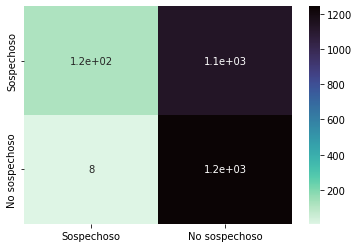

In [ ]:
print(classification_report(y_test,tree_rnd_pred))
cn=confusion_matrix(y_test,tree_rnd_pred)
sns.heatmap(cn,annot=True,cmap='mako_r', xticklabels=['Sospechoso','No sospechoso'],yticklabels=['Sospechoso','No sospechoso'])

In [ ]:
scores = cross_val_score(tree_rnd, X_train,y_train, cv=5)
print(scores)
print(scores.mean())

[0.52733333 0.506      0.514      0.526      0.50266667]
0.5152


### Random forest

In [ ]:
rf_para_grid={
  'n_estimators': list(range(150, 301, 50)),
  'max_features': ['auto', 'sqrt'],
  'max_depth': [int(x) for x in np.linspace(3, 10, num = 3)],
  'min_samples_split': [2, 5],
  'min_samples_leaf': [1, 2],
  'bootstrap': [True, False]
}

random_search(RandomForestClassifier(),X_train,y_train,rf_para_grid)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 6, 'bootstrap': False}


In [ ]:
random_rnd=RandomForestClassifier(**{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 6, 'bootstrap': False})
random_rnd.fit(X_train,y_train)
random_rnd_pred=random_rnd.predict(X_test)

print(f'The score for random forest with the train set is {random_rnd.score(X_train, y_train)}')
print(f'The score for random forest with the test set is {random_rnd.score(X_test, y_test)}')
print(f'The accuracy for random forest is {accuracy_score(y_test,random_rnd_pred)}')

El score para random forest con el set de train es 0.8756
El score para random forest con el set de test es 0.846
El accuracy para random forest es 0.846


              precision    recall  f1-score   support

           0       0.95      0.73      0.83      1250
           1       0.78      0.96      0.86      1250

    accuracy                           0.85      2500
   macro avg       0.87      0.85      0.84      2500
weighted avg       0.87      0.85      0.84      2500



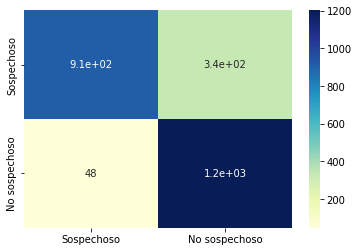

In [ ]:
print(classification_report(y_test,random_rnd_pred))
cn=confusion_matrix(y_test,random_rnd_pred)
sns.heatmap(cn,annot=True,cmap='YlGnBu', xticklabels=['Sospechoso','No sospechoso'],yticklabels=['Sospechoso','No sospechoso'])

In [ ]:
scores = cross_val_score(random_rnd, X_train,y_train, cv=5)
print(scores)
print(scores.mean())

[0.82933333 0.81       0.84733333 0.84       0.83066667]
0.8314666666666668


### XGBoost

In [ ]:
XGB_para_grid = {
    "learning_rate" : [0.05, 0.10],
    "max_depth" : [ 3, 4, 5],
    "min_child_weight" : [ 3, 5, 7 ],
    "gamma" : [ 0.0, 0.1],
    "colsample_bytree" : [ 0.3, 0.4]
  }

random_search(XGBClassifier(),X_train,y_train,XGB_para_grid)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
{'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.3}


In [ ]:
xgb_rnd=XGBClassifier(**{'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.3})
xgb_rnd.fit(X_train,y_train)
xgb_rnd_pred=xgb.predict(X_test)

print(f'The score for XGBoost with the train set is {xgb_rnd.score(X_train, y_train)}')
print(f'The score for XGBoost with the test set is {xgb_rnd.score(X_test, y_test)}')
print(f'The accuracy for XGBoost is {accuracy_score(y_test,xgb_rnd_pred)}')

El score para XGBoost con el set de train es 0.8278666666666666
El score para XGBoost con el set de test es 0.8248
El accuracy para XGBoost es 0.7924


              precision    recall  f1-score   support

           0       0.99      0.59      0.74      1250
           1       0.71      1.00      0.83      1250

    accuracy                           0.79      2500
   macro avg       0.85      0.79      0.78      2500
weighted avg       0.85      0.79      0.78      2500



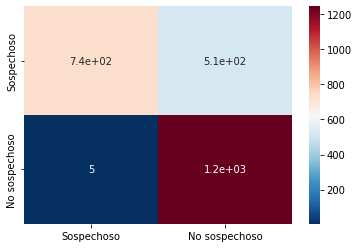

In [ ]:
print(classification_report(y_test,xgb_rnd_pred))
cn=confusion_matrix(y_test,xgb_rnd_pred)
sns.heatmap(cn,annot=True,cmap='RdBu_r', xticklabels=['Sospechoso','No sospechoso'],yticklabels=['Sospechoso','No sospechoso'])

In [ ]:
scores = cross_val_score(xgb_rnd, X_train,y_train, cv=5)
print(scores)
print(scores.mean())

[0.81533333 0.79733333 0.826      0.83666667 0.80466667]
0.8160000000000001


# Model Serialization

In [ ]:
with open('/content/content.drive/MyDrive/TP_Final/model.pkl', 'wb') as f_model:
    pickle.dump(logistic_rnd, f_model)

# Model Deserialization

In [ ]:
with open('/content/content.drive/MyDrive/TP_Final/model.pkl', 'rb') as f_model:
    model = pickle.load(f_model)

In [ ]:
model_pred=model.predict(X_test)

print(f'The score for random forest with the train set is {model.score(X_train, y_train)}')
print(f'The score for random forest with the test set is {model.score(X_test, y_test)}')
print(f'The accuracy for random forest is {accuracy_score(y_test,model_pred)}')

El score para random forest con el set de train es 1.0
El score para random forest con el set de test es 0.874
El accuracy para random forest es 0.874


# Testing with the best model

In [ ]:
text='my whole body feels itchy and like its on fire'
text=[text]
text_int=vector.transform(text)
prediction=model.predict(text_int)
prediction[0]

0

In [ ]:
text='Im the author of novels filled with family drama and romance'
text=[text]
text_int=vector.transform(text)
prediction=model.predict(text_int)
prediction[0]

1

# Data vs Data Clean


In [ ]:
data_raw= pd.read_csv('/content/content.drive/MyDrive/TP_Final/suspicious_tweets.csv')
data_raw.head()

,message,label
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",1
1,is upset that he can't update his Facebook by ...,1
2,@Kenichan I dived many times for the ball. Man...,1
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",1


In [ ]:
# run this cell to test with balanced classes
n_Class = 5000
label_raw_0=data_raw[data_raw['label']==0].sample(n=n_Class)
label_raw_1=data_raw[data_raw['label']==1].sample(n=n_Class)

data_raw = pd.concat([label_raw_1,label_raw_0])
data_raw=shuffle(data_raw)
data_raw.head()

,message,label
27461,i hate insomnia.,0
26194,@Alowrey17 Come home to me!! twitter is not th...,1
22096,tryinq to warm my leqs up its so cold over here,1
9678,A little sore from football practice.,1
24206,my bf hate me. i'm so sad,0


In [ ]:
X_raw=data_raw['message'].values
y_raw=data_raw['label'].values

vector_raw=TfidfVectorizer(lowercase=False)
vector_raw.fit(X_raw)
X_raw=vector_raw.fit_transform(X_raw)

In [ ]:
X_raw_train,X_raw_test,y_raw_train,y_raw_test=train_test_split(X_raw,y_raw,test_size=0.25, shuffle=True, random_state = 4, stratify=y_raw)

In [ ]:
logistic_raw=LogisticRegression()
logistic_raw.fit(X_raw_train,y_raw_train)
logistic_raw_pred=logistic_raw.predict(X_raw_test)
print(f'The score for logistic regression with the train set is {logistic_raw.score(X_raw_train,y_raw_train)}')
print(f'The score for logistic regression with the test set is {logistic_raw.score(X_raw_test,y_raw_test)}')
print(f'The accuracy for logistic regression is {accuracy_score(y_raw_test,logistic_raw_pred)}')

El score para regresion logistica con el set de train es 0.9328
El score para regresion logistica con el set de test es 0.8092
El accuracy para regresion logistica es 0.8092


              precision    recall  f1-score   support

           0       0.88      0.72      0.79      1250
           1       0.76      0.90      0.82      1250

    accuracy                           0.81      2500
   macro avg       0.82      0.81      0.81      2500
weighted avg       0.82      0.81      0.81      2500



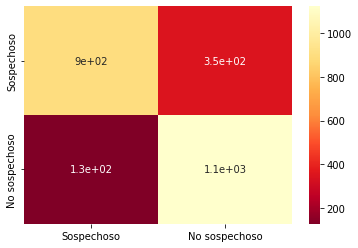

In [ ]:
print(classification_report(y_raw_test,logistic_raw_pred))
cn=confusion_matrix(y_raw_test,logistic_raw_pred)
sns.heatmap(cn,annot=True,cmap='YlOrRd_r',xticklabels=['Sospechoso','No sospechoso'],yticklabels=['Sospechoso','No sospechoso'])

# Pipeline

In [ ]:
#All in one, Implementation of the entire process for a model in a single execution
data= pd.read_csv('/content/content.drive/MyDrive/TP_Final/suspicious_tweets.csv')

#implementation of class balancing and data cleansing
cleaned_data = data.pipe(balance_classes).pipe(clean_dataset)

X=cleaned_data['message'].values
y=cleaned_data['label'].values

vector=TfidfVectorizer(lowercase=False)
vector.fit(X)
X=vector.fit_transform(X)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25, shuffle=True, random_state = 5, stratify=y)

#definition of steps to be followed by the pipeline with the model that best fits
pasos = [('logistic', LogisticRegression())]
#pipeline definition with declared steps
pipe = Pipeline(pasos)

#parameter setting according to the model that best fits
pipe.set_params(logistic__penalty='l2', logistic__C=100.0)

#model training
pipe.fit(X_train,y_train)

#prediction with test set
logistic_pipe_pred=pipe.predict(X_test)

print(f'The score for logistic regression with the train set is {pipe.score(X_train,y_train)}')
print(f'The score for logistic regression with the test set is {pipe.score(X_test,y_test)}')
print(f'The accuracy for logistic regression is {accuracy_score(y_test,logistic_pipe_pred)}')

El score para regresion logistica con el set de train es 0.9998666666666667
El score para regresion logistica con el set de test es 0.8748
El accuracy para regresion logistica es 0.8748


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
